# Curriculum Learning Visualization

Demonstrates adaptive curriculum progression through a 5-task linear dependency chain.

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from marin.rl.curriculum import (
    Curriculum,
    CurriculumConfig,
    LessonConfig,
    LessonDependency,
    compute_success_ratio,
)
from marin.rl.environments.base import EnvConfig
from marin.rl.types import RolloutStats

# Styling
sns.set_style("whitegrid")
sns.set_palette("husl", 5)
plt.rcParams["figure.dpi"] = 120

In [3]:
def create_success_trajectory(start_step: int, learning_speed: float, final_success: float, noise: float = 0.02):
    """Generate realistic sigmoid learning curve.

    Args:
        start_step: When learning begins (task unlocked).
        learning_speed: Rate of improvement (higher = faster learning).
        final_success: Asymptotic success rate.
        noise: Gaussian noise std for realism.

    Returns:
        Function that maps step -> reward.
    """
    rng = np.random.default_rng(42)

    def trajectory(step: int) -> float:
        if step < start_step:
            return 0.0
        progress = (step - start_step) * learning_speed
        # Sigmoid centered at progress=5
        base = final_success / (1 + np.exp(-progress + 5))
        return float(np.clip(base + rng.normal(0, noise), 0, 1))

    return trajectory

In [4]:
def simulate_linear_curriculum(num_steps: int = 800, seed: int = 42):
    """Simulate 5-task linear curriculum with plateau-only dependencies.

    Returns:
        Dictionary with simulation history:
        - steps: list of step numbers
        - success_rates: dict mapping lesson_id -> list of success rates
        - sampling_weights: dict mapping lesson_id -> list of sampling weights
        - events: list of (step, event_type, lesson_id) tuples
    """
    # 5-task linear chain: easy → medium → hard → expert → master
    lessons = {
        "easy": LessonConfig(
            lesson_id="easy",
            env_config=EnvConfig(env_class="marin.rl.environments.mock_env.MockEnv", env_args={}),
            stop_threshold=0.85,
        ),
        "medium": LessonConfig(
            lesson_id="medium",
            env_config=EnvConfig(env_class="marin.rl.environments.mock_env.MockEnv", env_args={}),
            dependencies=[LessonDependency(dependency_id="easy", reward_threshold=0.0)],
            stop_threshold=0.80,
        ),
        "hard": LessonConfig(
            lesson_id="hard",
            env_config=EnvConfig(env_class="marin.rl.environments.mock_env.MockEnv", env_args={}),
            dependencies=[LessonDependency(dependency_id="medium", reward_threshold=0.0)],
            stop_threshold=0.75,
        ),
        "expert": LessonConfig(
            lesson_id="expert",
            env_config=EnvConfig(env_class="marin.rl.environments.mock_env.MockEnv", env_args={}),
            dependencies=[LessonDependency(dependency_id="hard", reward_threshold=0.0)],
            stop_threshold=0.70,
        ),
        "master": LessonConfig(
            lesson_id="master",
            env_config=EnvConfig(env_class="marin.rl.environments.mock_env.MockEnv", env_args={}),
            dependencies=[LessonDependency(dependency_id="expert", reward_threshold=0.0)],
            stop_threshold=0.65,
        ),
    }

    config = CurriculumConfig(
        lessons=lessons,
        eval_frequency=50,
        eval_n_examples=32,
        eval_n_generations=1,
        minimum_sample_probability=0.01,
    )
    curriculum = Curriculum(config)

    # Define learning curves (progressively slower learning, lower asymptotic success)
    trajectories = {
        "easy": create_success_trajectory(0, 0.030, 0.90, noise=0.015),
        "medium": create_success_trajectory(150, 0.025, 0.85, noise=0.018),
        "hard": create_success_trajectory(320, 0.020, 0.78, noise=0.020),
        "expert": create_success_trajectory(500, 0.015, 0.72, noise=0.022),
        "master": create_success_trajectory(670, 0.010, 0.68, noise=0.025),
    }

    # Initialize history tracking
    history = {
        "steps": [],
        "success_rates": {lid: [] for lid in lessons},
        "sampling_weights": {lid: [] for lid in lessons},
        "events": [],
    }

    # Simulation loop
    for step in range(num_steps):
        curriculum.current_step = step

        # Track unlock and graduation events
        prev_unlocked = set(curriculum.unlocked)
        prev_graduated = set(curriculum.graduated)
        curriculum._unlock_and_graduate_lessons()

        for lid in curriculum.unlocked - prev_unlocked:
            history["events"].append((step, "unlock", lid))
        for lid in curriculum.graduated - prev_graduated:
            history["events"].append((step, "graduate", lid))

        # Sample lesson and generate rollout
        active_lessons = curriculum.unlocked - curriculum.graduated
        if active_lessons:
            lesson_id = curriculum.sample_lesson(jax.random.PRNGKey(step + seed))
            reward = trajectories[lesson_id](step)
            curriculum.update_lesson_stats(
                [RolloutStats(lesson_id=lesson_id, episode_reward=reward, env_example_id=f"ex_{step}")],
                mode="training",
                current_step=step,
            )

            # Periodic evaluation
            if step % config.eval_frequency == 0 and step > 0:
                for eval_lid in active_lessons:
                    eval_rewards = [trajectories[eval_lid](step) for _ in range(config.eval_n_examples)]
                    eval_stats = [
                        RolloutStats(lesson_id=eval_lid, episode_reward=r, env_example_id=f"eval_{step}_{i}")
                        for i, r in enumerate(eval_rewards)
                    ]
                    curriculum.update_lesson_stats(eval_stats, mode="eval", current_step=step)

        # Record state
        history["steps"].append(step)
        weights = curriculum.compute_sampling_weights()

        for lid in lessons:
            success = compute_success_ratio(curriculum.stats[lid], step)
            history["success_rates"][lid].append(success)
            history["sampling_weights"][lid].append(weights.get(lid, 0.0))

    return history

In [5]:
def plot_curriculum_progression(history: dict):
    """Visualize curriculum dynamics in a single figure with two subplots.

    Top: Success rate trajectories for each lesson.
    Bottom: Sampling weight distribution over time (stacked area).
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, height_ratios=[1, 1])
    fig.suptitle("Adaptive Curriculum: Linear 5-Task Progression", fontsize=16, fontweight="bold", y=0.995)

    steps = np.array(history["steps"])
    lesson_ids = ["easy", "medium", "hard", "expert", "master"]
    colors = sns.color_palette("husl", 5)

    # Top panel: Success trajectories
    for i, lid in enumerate(lesson_ids):
        success = history["success_rates"][lid]
        ax1.plot(steps, success, label=lid.capitalize(), linewidth=2.5, alpha=0.9, color=colors[i])

    # Mark unlock events with vertical lines
    for step, event_type, lid in history["events"]:
        if event_type == "unlock":
            idx = lesson_ids.index(lid)
            ax1.axvline(step, color=colors[idx], linestyle=":", alpha=0.4, linewidth=1.5)
            ax1.text(
                step, 0.97, "↓", ha="center", va="top", fontsize=12, color=colors[idx], fontweight="bold"
            )

    ax1.set_ylabel("Success Rate", fontsize=12, fontweight="bold")
    ax1.set_ylim(-0.05, 1.05)
    ax1.legend(loc="upper left", frameon=True, fontsize=10, ncol=5)
    ax1.grid(alpha=0.3, linewidth=0.5)
    ax1.set_title("Learning Progress by Task (↓ = unlock)", fontsize=13, pad=10)

    # Bottom panel: Sampling weights (stacked area)
    weight_arrays = np.array([history["sampling_weights"][lid] for lid in lesson_ids])
    ax2.stackplot(steps, *weight_arrays, labels=[l.capitalize() for l in lesson_ids], colors=colors, alpha=0.8)

    # Mark graduation events
    for step, event_type, lid in history["events"]:
        if event_type == "graduate":
            idx = lesson_ids.index(lid)
            ax2.axvline(step, color=colors[idx], linestyle="--", alpha=0.4, linewidth=1.5)
            ax2.text(
                step, 0.97, "✓", ha="center", va="top", fontsize=14, color=colors[idx], fontweight="bold"
            )

    ax2.set_xlabel("Training Step", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Sampling Weight", fontsize=12, fontweight="bold")
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc="upper right", frameon=True, fontsize=10, ncol=5)
    ax2.grid(alpha=0.3, linewidth=0.5)
    ax2.set_title("Curriculum Sampling Distribution (✓ = graduate)", fontsize=13, pad=10)

    plt.tight_layout()
    plt.show()

Simulating linear curriculum...
✓ Simulation complete
  Unlock events: 0
  Graduate events: 0


/var/folders/39/gnwx60fn045_0428g4s4fbbh0000gn/T/ipykernel_74967/3430901923.py:54: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/power/code/marin/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


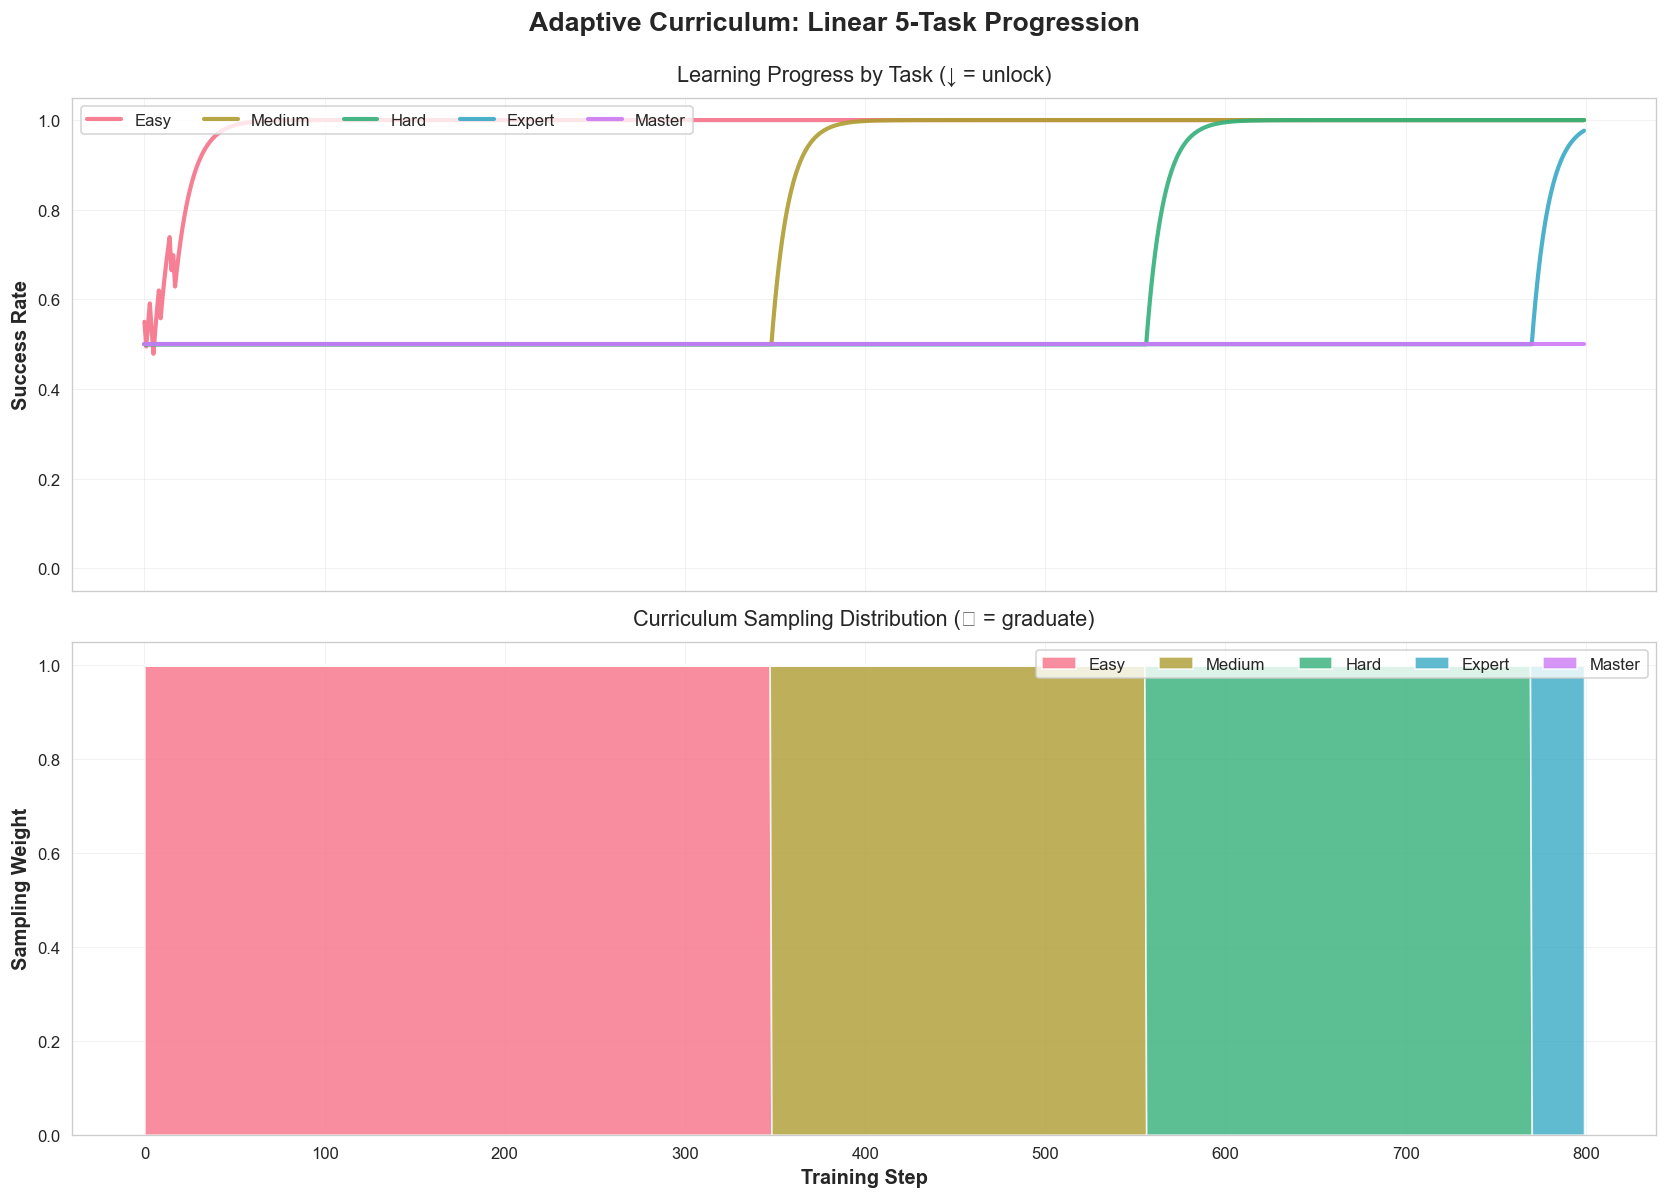

In [6]:
# Run simulation
print("Simulating linear curriculum...")
history = simulate_linear_curriculum(num_steps=800, seed=42)
print("✓ Simulation complete")
print(f"  Unlock events: {sum(1 for _, t, _ in history['events'] if t == 'unlock')}")
print(f"  Graduate events: {sum(1 for _, t, _ in history['events'] if t == 'graduate')}")

# Visualize
plot_curriculum_progression(history)